# Project report
### -- Implementing kmeans clustering
#### Lin Meng

### Overview:
The goal of this project is to implement the kmeans algorithm from scratch, then apply to image compression. This report discusses about some of details and path I've taken to accomplish the goal. 

The source code is in the _kmeans.py_ file, we import it here to present some of the examples and results.

In [1]:
%run kmeans

In [8]:
import numpy as np
from statistics import mode
from PIL import Image

### Section I: kmeans standard algorithm

**Code walk-through**:
1. Take the unique data points, and randomly select k of them as initial centroids.
2. Initialize the distance between previous and new centroids at a very large number, update the centroids until this distance is less than the tolerance level:
    - Construct a list of k empty lists to collect the index of points into the corresponding cluster.
    - Iterate through every point, computer the distances to each centroids, and put the point in the cluster where the distance is the smallest.
    - When all points are assigned to a cluster, take the average of each cluster as the new centroid.
    - Repeat this process until the centroids don't move anymore.

**Note**:
While the algorithm may look straightforward, one key note I'd like to mention is to keep track of the change in every iteration. The jth element of the clusters is the points associated with the jth centroid. But we need to reset the list of clusters every time we update the centroids.

In this section, we'll be implementing the standard kmeans algorithm on a 1-dimensional toy dataset.

In [3]:
# toy dataset with grades
grades = [92.65, 93.87, 74.06, 86.94, 92.26, 94.46, 92.94, 80.65, 92.86, 
          85.94, 91.79, 95.23, 85.37, 87.85, 87.71, 93.03]
# number of clusters we're interested
k = 3

Since our algorithm is based a n by p matrix input, where n is the number of points we want to cluster, and p is the number of features for the dsitance calculation. 

We need to transform the shape of the data in order to build clusterings.

In [5]:
# reshape the input data
grades = np.array(grades).reshape(-1, 1)

In [16]:
# convergence to local optimum
centroids, clusters = kmeans(grades, k)
print("centroids:", centroids)
print("vector sample indexes for clusters:", clusters)
for j in range(k):
    print("vector assignments:", grades[clusters[j]].reshape(1, -1))

centroids: [[92.58833333]
 [94.52      ]
 [84.07428571]]
vector sample indexes for clusters: [[0, 4, 6, 8, 10, 15], [1, 5, 11], [2, 3, 7, 9, 12, 13, 14]]
vector assignments: [[92.65 92.26 92.94 92.86 91.79 93.03]]
vector assignments: [[93.87 94.46 95.23]]
vector assignments: [[74.06 86.94 80.65 85.94 85.37 87.85 87.71]]


In the previous cell, we ended up having 3 centroids: 84.07, 92.59, 94.52. Given the range of the grades from 74 to 95, the first 2 centroids are too close to each other that doesn't make sense in this case.

Then we realized the clustering may converge to a local optimum, due to the randomness of initialization of centroids. So we gave it another shot:

In [13]:
# convergence to global optimum
centroids, clusters = kmeans(grades, k)
print("centroids:", centroids)
print("vector sample indexes for clusters:", clusters)
for j in range(k):
    print("vector assignments:", grades[clusters[j]].reshape(1, -1))

centroids: [[86.762     ]
 [77.355     ]
 [93.23222222]]
vector sample indexes for clusters: [[3, 9, 12, 13, 14], [2, 7], [0, 1, 4, 5, 6, 8, 10, 11, 15]]
vector assignments: [[86.94 85.94 85.37 87.85 87.71]]
vector assignments: [[74.06 80.65]]
vector assignments: [[92.65 93.87 92.26 94.46 92.94 92.86 91.79 95.23 93.03]]


This time, the centroids are 77.36, 86.76, and 93.23, which are a good representative of the data distribution.

So the question is, why is it converging to different statuses, and what we can we do to ensure the global optimum will be obtained?

For the first question, as mentioned above, the random initialization of centroids would likely to choose more than 1 centroid that are close enough, even after multiple iterations, they can't be effectively separated by simply averaging the nearby points in their respective clusters.

Therefore, we'd like to find a smarter way to initialize the centroids such that they are distant enough and have less overlap when clustering. This is called **kmeans++** initial centroid identification algorithm, which we will discuss in the next section.

### Section II: kmeans++ implementation

**Code walk-through**:
1. On top of the standard algorithm, we add an if statement to define a new way of picking the first set of centroids.
2. Firstly, randomly choose 1 point instead of k points as the centroid.
3. Update the remaining k-1 centroids one at a time. For each round, if a point has the highest distance to the existing centroids, choose it as the next centroid.
4. When the k centroids are filled, go back to the standard algorithm and follow the same rule to find convergence.

**Note**:
One way to reduce the time complexity of the algorithm is to compute the distances at the matrix level, instead of having nested loops.

Essentially, kmeans++ algorithm only differs from the standard one in that it keeps track of the initialization process instead of doing random pick.

Specifically, starting from the second centroid, we'll pick the next centroid that is most far away from the existing centroids. By doing so, we can have the centroids well distributed in the data points, and capture the clustering patterns to achieve better and more stable results.

In [17]:
# sample dataset from sklearn
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
cancer = 0
benign = 1
# number of clusters: cancer and benign
k = 2

To illustrate, we ran kmeans++ on a cancer dataset where 0 is cancer and 1 is benign. In this dataset, we have 30 features on 569 observations, which extend our previous 1-dimensional space.

In [27]:
# distribution of y
print("number of cancer:", sum(y == cancer))
print("number of benign:", sum(y == benign))

number of cancer: 212
number of benign: 357


In [21]:
# clustering based on kmeans++
centroids, clusters = kmeans(X, k=k, centroids="kmeans++", tolerance=.01)
print("number of obs in the 1st cluster:", len(clusters[0]))
print("number of obs in the 2nd cluster:", len(clusters[1]))

number of obs in the 1st cluster: 438
number of obs in the 2nd cluster: 131


Since it's a binary classification, we would like the algorithm to split 2 clusters out of it. As a result, 438 observations are included in the first cluster and 131 in the second. Compared to the value counts of target, it's very likely that the first cluster is for benign and the second is for cancer.

If we use the most votes in a cluster as the prediction for that cluster, we are able to produce a confusion matrix as follows. Here, T means benign and F means cancer. Despite the overall accuracy at 0.85, there are a number of false nagetives that the persons who got cancer are misclassified in the benign group.

In [28]:
# confusion matrix
likely_confusion_matrix(y, clusters)

       pred F  pred T
Truth
F         130      82
T           1     356
clustering accur 0.8541300527240774


### Section III: Application to image compression

One of the applications of kmeans is on image compression. No matter it's gray or color, the images are essentially matrices of pixels (numbers) with different dimensions. Hence we can cluster the numbers (colors) and assign the centroid color to all the pixels within that cluster, reducing the number of available colors to k, which compresses the image.

#### Part 1: Grayscale

Grayscale images have p=1 features, which is like our grades sample data. We transform the pixel matrix to n by 1 first, and then reassign the color based on the kmeans result.

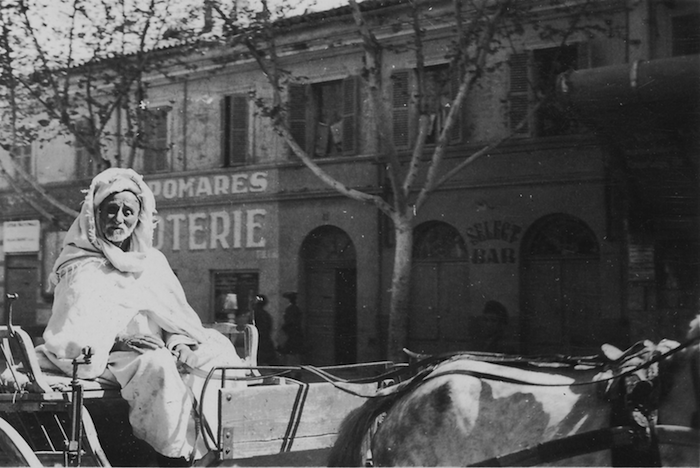

In [39]:
# gray example 1
img = Image.open('north-africa-1940s-grey.png')
img

After feeding into the algorithm, we found 4 centroids: 37, 70, 117, 183 between the 0 - 255 range. In the compressed image, all pixels would be one of the 4 values.

In [38]:
# compute clusters
X = np.array(img)
X_ = X.reshape(-1, 1)
k = 4
centroids, clusters = kmeans(X_, k=k, tolerance=.01)
centroids = centroids.astype(np.uint8)
print(centroids)

[[117]
 [ 37]
 [183]
 [ 70]]


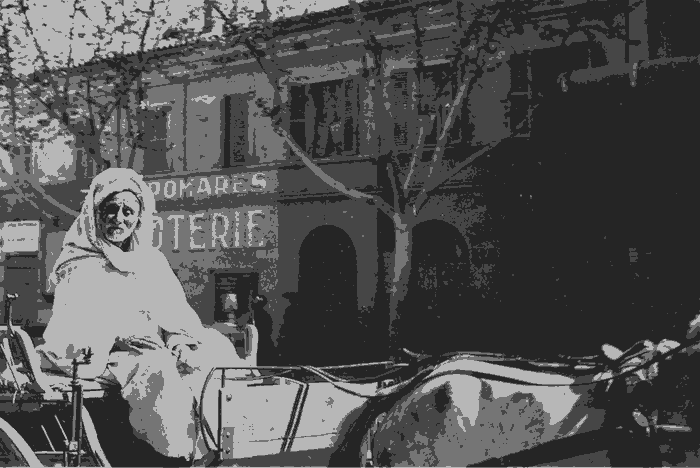

In [37]:
# reassign the colors
reassign_grey(X, centroids, clusters)
img_ = Image.fromarray(X, 'L') # L means grayscale
img_
# img_.show()

#### Part 2: Color

Different from grayscale images, color compression involves RGB 3-dimensional space. But in tersm of kmeans, all we need to do is to implement with p=3 features.

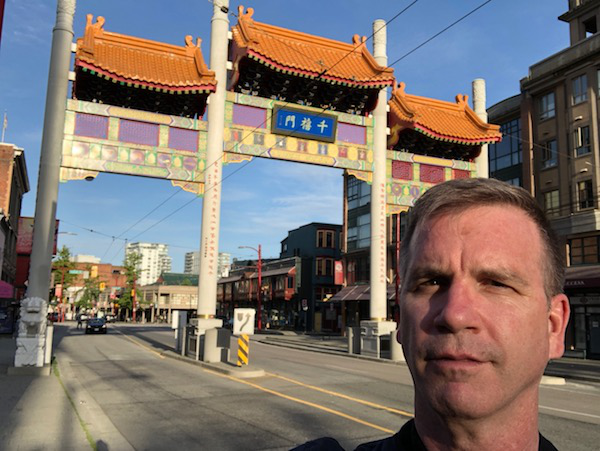

In [48]:
# color example 2
img = Image.open('parrt-vancouver.jpg')
img

Notice here we reshape the h by w by 3 image to a n by 3 matrix, so our kmeans algorithm can work on the RGB values of each pixel to classify into one of the 32 clusters.

In [52]:
# 32 centroids for color image
X = np.array(img)
X_ = X.reshape(-1, 3)
k = 32
centroids, clusters = kmeans(X_, k=k, centroids='kmeans++', tolerance=.01)
centroids = centroids.astype(np.uint8)
print(centroids[:5])

[[155 189 218]
 [ 64  65  66]
 [145 134 113]
 [127 118 101]
 [161  76  38]]


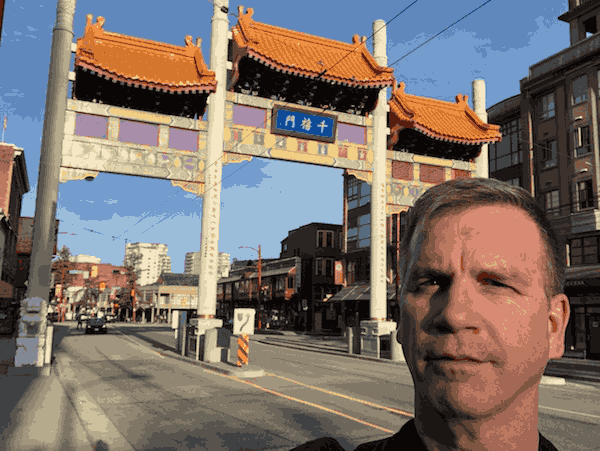

In [53]:
# reassign the colors
reassign_colors(X, centroids, clusters)
img_ = Image.fromarray(X)
img_

One last example with image compression, still looks great.

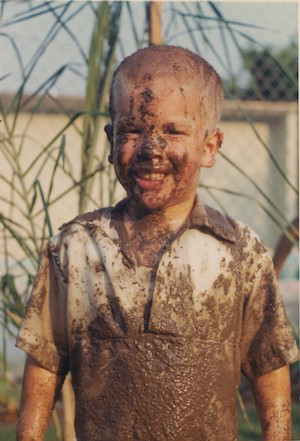

In [56]:
# color example 3
img = Image.open('parrt.jpg')
img

In [57]:
X = np.array(img)
X_ = X.reshape(-1, 3)
k = 32
centroids, clusters = kmeans(X_, k=k, centroids='kmeans++', tolerance=.01)
centroids = centroids.astype(np.uint8)
print(centroids[:5])

[[131 117  95]
 [183 186 180]
 [150 108  83]
 [183 172 153]
 [ 44  34  34]]


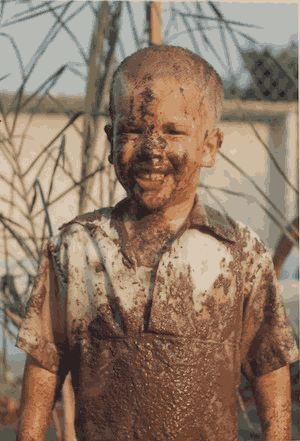

In [58]:
reassign_colors(X, centroids, clusters)
img_ = Image.fromarray(X)
img_

### Summary:
- Standard algorithm doesn't guarantee the unique convergence, while kmeans++ is more powerful way to facilitate the process.
- During the algorithm implementation, most of the errors I got were because the dimensions of the operations were not aligned up. It took a long time to debug.
- Image compression took longer than I expected, one improvement could be rewriting the calculations using matrix form.